In [1]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

dataset = np.load('dataset.npy', allow_pickle=True)

d_dataset = dataset[1]



2023-08-04 12:29:28.963499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit as conditional labels
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(d_dataset[0][1][1]))]

init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

init_gen_weights



<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[ 2.34843564, -1.34353349,  1.55220452],
        [-1.5651683 , -1.05813207, -3.1335391 ],
        [ 0.1426324 , -0.93997463, -1.26962145],
        [ 1.73922994, -1.04712205,  2.71493771],
        [ 2.13769785, -0.34382531,  2.3877154 ],
        [-1.35101466, -1.26463061,  1.56794042],
        [ 2.54154365,  1.46894927,  0.79046065],
        [ 1.71231585,  1.70109783, -0.88346274],
        [-1.06558205,  1.03334658,  2.27884376],
        [ 1.40359065, -1.87673102, -0.18139666],
        [-2.58687922,  2.38928895, -0.56637897],
        [-0.82662052,  2.61350673, -1.75174545],
        [-1.59012762, -2.51102762,  1.59205618],
        [ 1.96032365,  0.33076141,  2.29902473],
        [-1.89085576, -1.72517118, -2.95671568]],

       [[ 1.83193036, -0.86817868, -0.43590159],
        [-2.53662841,  1.08146954, -1.96942536],
        [ 2.53666893, -0.01535664,  2.22634354],
        [-0.76710035, -0.91611974,  2.10063123],
  

In [11]:
# Testing generator circuit QNode
gen_circuit(d_dataset[0][1][0], init_gen_weights)

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.0011240629999187957>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.05473222893144414>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.005277799357791879>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.0021214559588551007>]

In [12]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 19]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

discriminator = make_discrim()
discriminator.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 16)             320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             272       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1, 16)             0         
                                                                 
 dropout_1 (Dropout)         (None, 1, 16)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 128)            2176      
                                                                 
 dense_3 (Dense)             (None, 1, 1)             

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)



In [14]:


def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc



In [15]:


gloss = []
dloss = []
acc_results = []
epoch_acc_results = []

EPOCHS = 250
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w

new_gen_w = train(d_dataset[0], EPOCHS, start_epoch=1) 



KeyboardInterrupt: 

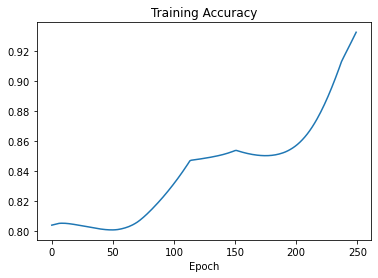

In [9]:
plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

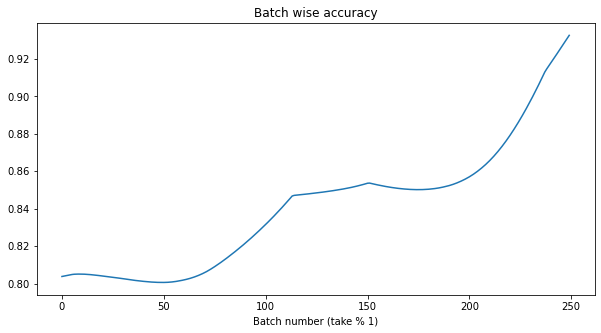

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

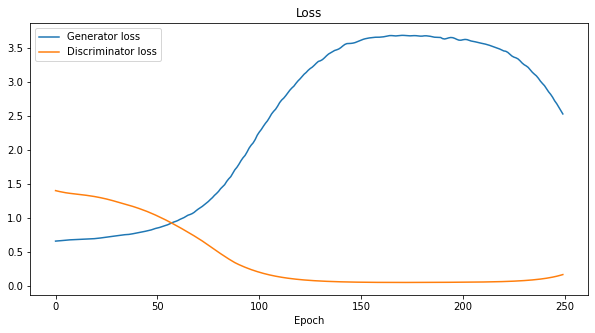

In [11]:


plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()



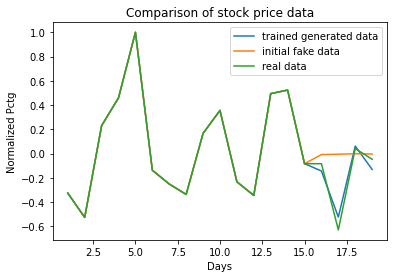

In [15]:
for i in range(batch_size):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], init_gen_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("Comparison of stock price data")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg")
    plt.legend()
    plt.show()

In [26]:
# Alternatively, you can visualize the circuit using circuit_drawer
circuit_drawer(gen_circuit)

┌───────┐┌───────────────┐              ┌─────────────┐                »
 q_0: ┤ Rx(0) ├┤0              ├─■────────────┤ Rx(0.55412) ├────────────────»
      ├───────┤│  Rxx(-2.3603) │ │ZZ(-1.7582) ├─────────────┴┐               »
 q_1: ┤ Rx(0) ├┤1              ├─■────────────┤0             ├─■─────────────»
      ├───────┤└───────────────┘              │  Rxx(1.2759) │ │ZZ(-0.84543) »
 q_2: ┤ Rx(0) ├───────────────────────────────┤1             ├─■─────────────»
      ├───────┤                               └──────────────┘               »
 q_3: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_4: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_5: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_6: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_7: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_8: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
 q_9: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
q_10: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
q_11: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
q_12: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
q_13: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      ├───────┤                                                              »
q_14: ┤ Rx(0) ├──────────────────────────────────────────────────────────────»
      └───────┘                                                              »
«                                                                  »
« q_0: ────────────────────────────────────────────────────────────»
«        ┌────────────┐                                            »
« q_1: ──┤ Rx(2.4262) ├────────────────────────────────────────────»
«      ┌─┴────────────┴┐              ┌─────────────┐              »
« q_2: ┤0              ├─■────────────┤ Rx(-2.6863) ├──────────────»
«      │  Rxx(-1.6805) │ │ZZ(0.89577) ├─────────────┴┐             »
« q_3: ┤1              ├─■────────────┤0             ├─■───────────»
«      └───────────────┘              │  Rxx(1.7846) │ │ZZ(1.1305) »
« q_4: ───────────────────────────────┤1             ├─■───────────»
«                                     └──────────────┘             »
« q_5: ────────────────────────────────────────────────────────────»
«                                                                  »
« q_6: ────────────────────────────────────────────────────────────»
«                                                                  »
« q_7: ────────────────────────────────────────────────────────────»
«                                                                  »
« q_8: ────────────────────────────────────────────────────────────»
«                                                                  »
« q_9: ────────────────────────────────────────────────────────────»
«                                                                  »
«q_10: ────────────────────────────────────────────────────────────»
«                                      